# Features available with the new kernels

By default Jupyter notebook comes with a `Python` kernel. sparkmagic provides two additional kernels that you can use with Jupyter. These are:

1. **PySpark** (for applications written in Python). PySpark kernel exposes the Spark programming model to Python
2. **Spark** (for applications written in Scala)

------------
## How do I use the new kernels? 

1. Create a notebook with the new kernels. Click **New**, and then click **PySpark** or **Spark**. 
![Create notebooks with new kernels](https://mysstorage.blob.core.windows.net/notebookimages/overview/jupyter-kernels.png "Create notebooks with new kernels") 
2. This should open a new notebook with the kernel you selected.

----------
## Notebook setup

When using PySpark kernel notebooks, there is no need to create a SparkContext or a HiveContext; those are all created for you automatically when you run the first code cell, and you'll be able to see the progress printed. The contexts are created with the following variable names:
- SparkContext (sc)
- HiveContext (sqlContext)

Everytime you run a cell, your web browser window title will show a **(Busy)** status along with the notebook title. You will also see a solid circle next to the **PySpark** text in the top-right corner. After the job completes, this will change to a hollow circle.

![Status of a Jupyter notebook job](https://mysstorage.blob.core.windows.net/notebookimages/overview/HDI.Spark.Jupyter.Job.Status.png "Status of a Jupyter notebook job")

----------
## PySpark magics 

The PySpark kernel provides some predefined “magics”, which are special commands that you can call with `%%` (e.g. `%%MAGIC` <args>). The magic command must be the first word in a code cell and allow for multiple lines of content. You can’t put comments before a cell magic.

For more information on magics, see [here](http://ipython.readthedocs.org/en/stable/interactive/magics.html).

### Help magic (%%help)

This magic gives you information about the different supported magics in PySpark kernel and the usage for each. 

In [1]:
%%help

Magic,Example,Explanation
info,%%info,Outputs session information for the current Livy endpoint.
cleanup,%%cleanup -f,"Deletes all sessions for the current Livy endpoint, including this notebook's session. The force flag is mandatory."
delete,%%delete -f -s 0,Deletes a session by number for the current Livy endpoint. Cannot delete this kernel's session.
logs,%%logs,Outputs the current session's Livy logs.
configure,"%%configure -f{""executorMemory"": ""1000M"", ""executorCores"": 4}",Configure the session creation parameters. The force flag is mandatory if a session has already been created and the session will be dropped and recreated.Look at Livy's POST /sessions Request Body for a list of valid parameters. Parameters must be passed in as a JSON string.
sql,%%sql -o tables -qSHOW TABLES,"Executes a SQL query against the sqlContext. Parameters: -o VAR_NAME: The result of the query will be available in the %%local Python context as a Pandas dataframe. -q: The magic will return None instead of the dataframe (no visualization). -m METHOD: Sample method, either take or sample. -n MAXROWS: The maximum number of rows of a SQL query that will be pulled from Livy to Jupyter. If this number is negative, then the number of rows will be unlimited. -r FRACTION: Fraction used for sampling."
local,%%locala = 1,All the code in subsequent lines will be executed locally. Code must be valid Python code.


### Session information (%%info)

Livy is an open source REST server for Spark. When you execute a code cell in a PySpark notebook, it creates a Livy session to execute your code. You can use the `%%info` magic to display the current Livy session information. 

In [2]:
%%info

### Session configuration (%%configure)
 
Use the `%%configure` magic to configure new or existing Livy sessions.
* If a session is already running, you can change the configuration by using the `-f` argument with `%%configure` magic. This will delete the current session and recreate it with the applied configurations. If you don't provide the `-f` argument, an error will be displayed and no configuration changes will be applied.
* If you haven't already started the session, then the `-f` argument is not mandatory. Even if you use it with a session that you are just creating, it will not delete any currently running sessions.




These are some session attributes that can be used for configuration 
- **"name"**: Name of the application
- **"driverMemory"**: Memory for driver (e.g. 1000M, 2G) 
- **"executorMemory"**: Memory for executor (e.g. 1000M, 2G) 

For more attributes for session configuration see <a href="https://github.com/cloudera/livy/tree/6fe1e80cfc72327c28107e0de20c818c1f13e027#post-sessions" target="_blank"> the Livy documentation</a>.

> **TIP**: The application name should start with `remotesparkmagics` to allow sessions to get automatically cleaned up if an error happened. If you provide a name that does not start with `remotesparkmagics` it will not result in an error but the cleanup won't occur.

In [3]:
%%configure -f 
{"name":"remotesparkmagics-sample", "executorMemory": "4G", "executorCores":4}

----------
## Automatic visualization of queries 

The Pyspark kernel automatically visualizes the output of SQL (HiveQL) queries. You are given the option to choose between several different types of visualizations:
- Table
- Pie
- Line 
- Area
- Bar

>**TIP**: When you perform a SQL query, the number of rows of data that will be included in the result data set will be limited by default to 2500 rows. 

### SQL magic (%%sql)

The PySpark kernel supports easy inline HiveQL queries against the `sqlContext`. The (`-o VARIABLE_NAME`) argument persists the output of the SQL query as a <a href="http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html" target="_blank">Pandas dataframe</a> on the Jupyter server (e.g. `-o query1` in the example below). This means it'll be available in the local mode which will be explained later. The output will be automatically visualized after you run the cell below.

In [1]:
%%sql -o query1
SELECT 1, 2, 3

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
4,None,pyspark,idle,,,✔


SparkSession available as 'spark'.


/home/itamarst/Devel/sparkmagic/autovizwidget/autovizwidget/widget/utils.py:50: FutureWarning:

A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.



Output()

![widget](images/widget.PNG)

In addition to `-o`, a number of other configuration parameters for SQL queries are available (as described in the `%%help` output above). These include:

* `-q`. This causes the magic to return `None`, turning off visualizations for that cell. If you don't want to auto-visualize the content of a cell and just want to capture it as a dataframe, then use `-q -o VARIABLE`. If you want to turn off visualizations without capturing the results (e.g. for running a SQL query with side effects, like a `CREATE TABLE` statement), just use `-q` without specifying a `-o` argument.

> Remember that the kernel by default limits the output of a SQL query to 2500 rows. If you want to adjust this default behavior, use these options.

* `-m METHOD`, where `METHOD` is either `take` or `sample` (defaults to `take`). If the method is `take`, the kernel will take elements from the top of the result data set; if the method is `sample`, the kernel will randomly sample elements of the data set according to `-r`, described below.

* `-r FRACTION`, where `FRACTION` is some floating-point number between 0.0 and 1.0. If the sample method for the SQL query is `sample`, then the kernel will randomly sample this fraction of the elements of the result set for you; e.g. if you run a SQL query with the arguments `-m sample -r 0.01`, then 1% of the result rows will be randomly sampled.

* `-n MAXROWS`, where `MAXROWS` is some integer. The kernel will limit the number of output rows to `MAXROWS`. If `MAXROWS` is a negative number such as `-1`, then the number of rows in the result set will not be limited.

> **WARNING**: Be careful with the `-n` option, as it is possible to cause the Jupyter server to run out of memory if you try to collect too many result rows. We recommend only using `-n -1` if you are certain that the result dataset will not be too large.

As a final example, this SQL query randomly samples 10% of the rows in the **hivesampletable**, limits the size of the result set to 500, and saves the output into a dataframe called `query2` without doing any visualizations.

In [5]:
%%sql -q -m sample -r 0.1 -n 500 -o query2 
SELECT * FROM hivesampletable

### Server-side rendering

You can render images on the server and then display them locally. First, we create the image:

In [2]:
import matplotlib.pyplot as plt

df = spark.read.json("/apps/spark-2.3.3/examples/src/main/resources/people.json")
df.createOrReplaceTempView("people")
df.toPandas().plot.bar(x='name',y='age')

And then we render it locally using the `%matplot` magic:

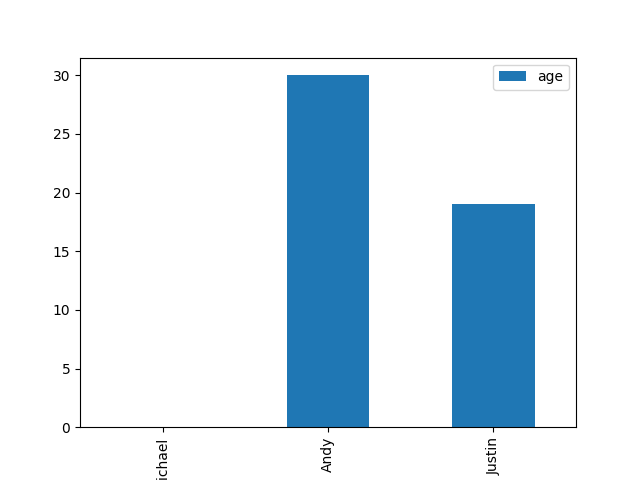

In [3]:
%matplot plt

### Running locally (%%local)

You can use the `%%local` magic to run your code locally on the Jupyter server without going to Spark. Here's a typical use case for this scenario. 

By default, the output of any code snippet that you run from a Jupyter notebook is available within the context of the session that is persisted on the worker nodes. However, if you want to save a trip to the worker nodes for every computation, and all the data that you need for your computation is available locally on the Jupyter server node (which is the headnode), you can use the `%%local` magic to run the code snippet on the Jupyter server. Typically, you would use `%%local` magic in conjunction with the `%%sql` magic with `-o` parameter. The `-o` parameter would persist the output of the SQL query locally and then `%%local` magic would trigger the next set of code snippet to run locally against the output of the SQL queries that is persisted locally.

> **TIPS**: 
> * Working against locally persisted data is especially useful when you want the flexibility of using visualization libraries such as **matplotlib**. If you work directly against the data on the remote worker nodes, the output received through Livy is always text that limits the options of visual representation.


> * Remember that SQL queries, by default, limit the number of result rows to 2500 -- and that it is possible to get Out of Memory errors if you accidentally collect too many results from your SQL query. Therefore, if your dataset is large, it is considered a best practice to do your computation or number-crunching on the cluster or in the SQL query rather than in local mode.

When you use `%%local` all subsequent lines in the cell will be executed locally. The code in the cell must be valid Python code.

This code block prints the length of the result set of the dataframe `query2` -- remember, we used the `-n 500` option to limit the size of the dataframe to 500.

In [6]:
%%local
print(len(query2))

500


### Session logs (%%logs)

You can get the logs of your current Livy session to debug any issues you encounter.

In [7]:
%%logs

16/06/09 23:43:28 WARN SparkConf: The configuration key 'spark.yarn.applicationMaster.waitTries' has been deprecated as of Spark 1.3 and and may be removed in the future. Please use the new key 'spark.yarn.am.waitTime' instead.
16/06/09 23:43:28 WARN SparkConf: The configuration key 'spark.yarn.applicationMaster.waitTries' has been deprecated as of Spark 1.3 and and may be removed in the future. Please use the new key 'spark.yarn.am.waitTime' instead.
16/06/09 23:43:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/09 23:43:30 INFO TimelineClientImpl: Timeline service address: http://localhost:8188/ws/v1/timeline/
16/06/09 23:43:30 INFO Client: Requesting a new application from cluster with 10 NodeManagers
16/06/09 23:43:30 INFO Client: Verifying our application has not requested more than the maximum memory capability of the cluster (25600 MB per container)
16/06/09 23:43:30 INFO Client: Will allocate 

### Delete session (%%delete)

Use '`%%delete -f -s <session #>`' to delete a session given its session ID. Note that you cannot delete the session that is initiated for the kernel itself. Another notebook might go into an error state, since notebooks are supposed to manage sessions by themselves, and all work will be lost on that session.

### Sessions cleanup (%%cleanup)

Use '`%%cleanup -f`' magic to delete all of the sessions for this cluster, including this notebook's session.
The force flag `-f` is mandatory.